# Contact mechanics

In [1]:
# [collapse: code] Colab Setup (Install Dependencies)

# Only run this if we are in Google Colab
if "google.colab" in str(get_ipython()):
    print("Installing dependencies from pyproject.toml...")
    # This installs the repo itself (and its dependencies)
    !apt-get install gmsh 
    !apt-get install -qq xvfb libgl1-mesa-glx
    !pip install pyvista -qq
    !pip install -q "git+https://github.com/smec-ethz/tatva-docs.git"    

    import pyvista as pv

    pv.global_theme.jupyter_backend = "static"
    pv.global_theme.notebook = True
    pv.start_xvfb()

    print("Installation complete!")

In this notebook, we model the circular punch of a sphere on a deformable plane.

We impose the contact constraint via a penalty approach by extending the total energy functional with a contact contribution $\Psi_c$, defined by the penalty density

$$
\psi_c =\frac{1}{2} \kappa~ g(\boldsymbol{u}_1, \boldsymbol{u}_2)^2~,
$$

where $g$ represents the normal gap function and $\kappa$ denotes the penalty parameter. The resulting total energy functional reads

\begin{equation}
\Psi(\boldsymbol{u}_1, \boldsymbol{u}_2) = \int_{\Omega_{\mathrm{sphere}}}\psi_\varepsilon(\boldsymbol{u}_1)~\mathrm{d\Omega} + \int_{\Omega_{\mathrm{cube}}}\psi_\varepsilon(\boldsymbol{u}_2)~\mathrm{d\Omega} +\int_{\mathrm{S}_c}\psi_c(\boldsymbol{u}_1, \boldsymbol{u}_2) ~\mathrm{dS} ~ .
\end{equation}

In [49]:
import gmsh
import jax
import jax.numpy as jnp
import pyvista as pv
from jax import Array
from jax_autovmap import autovmap
from tatva import Mesh, Operator

jax.config.update("jax_enable_x64", True)
pv.global_theme.jupyter_backend = "static"

## Meshing

We generate two separate meshes with `gmsh`; one for the cube, another one for the sphere.

In [15]:
# [collapse: code] Code for generating the mesh

import math
import os

import gmsh
import numpy as np


def extract_mesh() -> tuple[Mesh, dict[str, np.ndarray]]:
    node_tags, coords, _ = gmsh.model.mesh.getNodes()
    nodes_arr = np.array(coords).reshape(-1, 3)

    # Gmsh tags are 1-based and potentially non-contiguous.
    # We map them to 0-based indices for JAX.
    tag_map = {tag: i for i, tag in enumerate(node_tags)}

    # 5. Extract Tetrahedral Elements
    # Element Type 4 is 4-node Tetrahedron
    # getElementsByType returns: (element_tags, node_tags)
    try:
        _, elem_node_tags = gmsh.model.mesh.getElementsByType(4)
        elem_node_tags = np.array(elem_node_tags).reshape(-1, 4)
    except ValueError:
        gmsh.finalize()
        raise

    # Remap tags to 0-based indices
    # Vectorized map using a lookup array if tags are contiguous,
    # but loop is safer for general Gmsh output.
    elements_array = np.array(
        [[tag_map[tag] for tag in elem] for elem in elem_node_tags]
    )

    # --- physical surfaces: collect 2D triangle faces (Tri3 = type 2) per physical group ---
    # Returns: dict[name:str] -> np.ndarray[int] of shape (ntri, 3) with 0-based node indices
    physical_surfaces: dict[str, np.ndarray] = {}

    for dim, pg_tag in gmsh.model.getPhysicalGroups(dim=2):
        name = gmsh.model.getPhysicalName(dim, pg_tag)

        # Entities (surface tags) that belong to this physical group
        entities = gmsh.model.getEntitiesForPhysicalGroup(dim, pg_tag)

        tris = []
        for ent in entities:
            # Get all mesh elements on this surface entity
            types, _, node_tags_by_type = gmsh.model.mesh.getElements(dim, ent)

            for etype, ntags in zip(types, node_tags_by_type):
                if etype != 2:  # Tri3 only
                    continue
                tri_nodes = np.array(ntags, dtype=np.int64).reshape(-1, 3)
                tris.append(tri_nodes)

        if not tris:
            physical_surfaces[name] = np.zeros((0, 3), dtype=np.int32)
            continue

        tri_nodes = np.vstack(tris)
        tri_nodes_0 = np.array(
            [[tag_map[t] for t in tri] for tri in tri_nodes], dtype=np.int32
        )
        physical_surfaces[name] = tri_nodes_0

    return Mesh(
        coords=np.array(nodes_arr),
        elements=np.array(elements_array),
    ), physical_surfaces


def get_mesh_cube(
    h_min: float, h_max: float, h_corner: float
) -> tuple[Mesh, dict[str, np.ndarray]]:
    ox, oy, oz = (0.0, 0.0, 0.0)
    lx, ly, lz = (1.0, 1.0, -1.0)

    gmsh.initialize()
    gmsh.model.add("cube")

    gmsh.option.setNumber("General.Terminal", 1)
    gmsh.option.setNumber("Mesh.MshFileVersion", 4.1)
    gmsh.option.setNumber("Mesh.ElementOrder", 1)
    gmsh.option.setNumber("Mesh.Algorithm3D", 4)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", min(h_min, h_corner))
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", h_max)

    # ---- 1) points (we keep the tags we care about) ----
    p000 = gmsh.model.occ.addPoint(ox, oy, oz)  # corner of interest for refinement
    p100 = gmsh.model.occ.addPoint(ox + lx, oy, oz)
    p110 = gmsh.model.occ.addPoint(ox + lx, oy + ly, oz)
    p010 = gmsh.model.occ.addPoint(ox, oy + ly, oz)

    # ---- 2) curves + base surface (z = oz) ----
    l01 = gmsh.model.occ.addLine(p000, p100)
    l12 = gmsh.model.occ.addLine(p100, p110)
    l23 = gmsh.model.occ.addLine(p110, p010)
    l30 = gmsh.model.occ.addLine(p010, p000)

    cloop = gmsh.model.occ.addCurveLoop([l01, l12, l23, l30])
    s_base = gmsh.model.occ.addPlaneSurface([cloop])

    # ---- 3) volume via extrusion; capture returned entity tags (no searching) ----
    # extrude returns a list of (dim, tag). For a surface extrusion, you get:
    #   - one top surface (dim=2),
    #   - one volume (dim=3),
    #   - lateral surfaces (dim=2) ...
    out = gmsh.model.occ.extrude([(2, s_base)], 0.0, 0.0, lz)

    vol_tag = next(tag for (dim, tag) in out if dim == 3)

    gmsh.model.occ.synchronize()

    # ---- refinement field around p000 (no point lookup loop) ----
    dist = gmsh.model.mesh.field.add("Distance")
    gmsh.model.mesh.field.setNumbers(dist, "PointsList", [p000])

    thr = gmsh.model.mesh.field.add("Threshold")
    gmsh.model.mesh.field.setNumber(thr, "IField", dist)
    gmsh.model.mesh.field.setNumber(thr, "LcMin", h_corner)
    gmsh.model.mesh.field.setNumber(thr, "LcMax", h_max)
    gmsh.model.mesh.field.setNumber(thr, "DistMin", h_corner * 10)
    gmsh.model.mesh.field.setNumber(thr, "DistMax", 0.5)
    gmsh.model.mesh.field.setAsBackgroundMesh(thr)

    # ---- physical groups (using known tags) ----
    vol_pg = gmsh.model.addPhysicalGroup(3, [vol_tag], tag=1)
    gmsh.model.setPhysicalName(3, vol_pg, "cube_volume")

    top_pg = gmsh.model.addPhysicalGroup(2, [s_base], tag=2)
    gmsh.model.setPhysicalName(2, top_pg, "cube_top")

    gmsh.model.mesh.generate(3)

    mesh = extract_mesh()
    gmsh.finalize()
    return mesh


def mesh_bottom_eighth_sphere(
    radius: float, h_min: float, h_max: float, h_corner: float
) -> tuple[Mesh, dict[str, np.ndarray]]:
    r_ref = 0.6 * radius

    gmsh.initialize()
    gmsh.model.add("bottom_eighth_sphere")

    gmsh.option.setNumber("General.Terminal", 1)
    gmsh.option.setNumber("Mesh.MshFileVersion", 4.1)
    gmsh.option.setNumber("Mesh.ElementOrder", 1)
    gmsh.option.setNumber("Mesh.Algorithm3D", 4)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", min(h_min, h_corner))
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", h_max)

    sphere_tag = gmsh.model.occ.addSphere(0.0, 0.0, radius, radius)
    box_tag = gmsh.model.occ.addBox(0.0, 0.0, 0.0, radius, radius, radius)

    out = gmsh.model.occ.intersect(
        [(3, sphere_tag)], [(3, box_tag)], removeObject=True, removeTool=True
    )
    gmsh.model.occ.synchronize()

    vol_tag = out[0][0][1]

    # ---- refinement field at corner (0,0,0) ----
    # use Distance field with an explicit point; no need to find an existing CAD vertex
    p_corner = gmsh.model.occ.addPoint(0.0, 0.0, 0.0)
    gmsh.model.occ.synchronize()

    dist = gmsh.model.mesh.field.add("Distance")
    gmsh.model.mesh.field.setNumbers(dist, "PointsList", [p_corner])

    thr = gmsh.model.mesh.field.add("Threshold")
    gmsh.model.mesh.field.setNumber(thr, "IField", dist)
    gmsh.model.mesh.field.setNumber(thr, "LcMin", h_corner)
    gmsh.model.mesh.field.setNumber(thr, "LcMax", h_max)
    gmsh.model.mesh.field.setNumber(thr, "DistMin", h_corner * 10)
    gmsh.model.mesh.field.setNumber(thr, "DistMax", r_ref)
    gmsh.model.mesh.field.setAsBackgroundMesh(thr)

    # --- identify spherical boundary surface by OCC type ---
    boundary = gmsh.model.getBoundary([(3, vol_tag)], oriented=False)

    tol = 1e-6  # << much looser than 1e-10

    boundary = gmsh.model.getBoundary([(3, vol_tag)], oriented=False)

    sphere_candidates = []
    for dim, tag in boundary:
        if dim != 2:
            continue
        xmin, ymin, zmin, xmax, ymax, zmax = gmsh.model.getBoundingBox(2, tag)

        is_x0 = abs(xmin - 0.0) < tol and abs(xmax - 0.0) < tol
        is_y0 = abs(ymin - 0.0) < tol and abs(ymax - 0.0) < tol
        is_zr = abs(zmin - radius) < tol and abs(zmax - radius) < tol

        if not (is_x0 or is_y0 or is_zr):
            sphere_candidates.append(tag)

    if len(sphere_candidates) != 1:
        raise RuntimeError(
            f"Expected 1 spherical face, got {len(sphere_candidates)}: {sphere_candidates}"
        )

    curved_surface = sphere_candidates[0]

    vol_pg = gmsh.model.addPhysicalGroup(3, [vol_tag], tag=1)
    gmsh.model.setPhysicalName(3, vol_pg, "sphere_bottom_eighth")

    surf_pg = gmsh.model.addPhysicalGroup(2, [curved_surface], tag=2)
    gmsh.model.setPhysicalName(2, surf_pg, "sphere_outer")

    gmsh.model.mesh.generate(3)

    mesh = extract_mesh()
    gmsh.finalize()
    return mesh

In [4]:
# [collapse: code] Code for visualizing the mesh with PyVista
pv.set_jupyter_backend("client")


def get_pyvista_grid(mesh, cell_type="quad"):
    if mesh.coords.shape[1] == 2:
        pv_points = np.hstack((mesh.coords, np.zeros(shape=(mesh.coords.shape[0], 1))))
    else:
        pv_points = np.array(mesh.coords)

    cell_type_dict = {
        "quad": 4,
        "triangle": 3,
        "tetra": 4,
        "hexahedron": 8,
    }

    pv_cells = np.hstack(
        (
            np.full(
                fill_value=cell_type_dict[cell_type], shape=(mesh.elements.shape[0], 1)
            ),
            mesh.elements,
        )
    )

    pv_cell_type_dict = {
        "quad": pv.CellType.QUAD,
        "triangle": pv.CellType.TRIANGLE,
        "tetra": pv.CellType.TETRA,
        "hexahedron": pv.CellType.HEXAHEDRON,
    }
    cell_types = np.full(
        fill_value=pv_cell_type_dict[cell_type], shape=(mesh.elements.shape[0],)
    )

    grid = pv.UnstructuredGrid(pv_cells.flatten(), cell_types, pv_points)

    return grid

In [55]:
# [output: hide]
#
h_min = 0.01
h_max = 0.3
h_corner = 0.002

mesh_cube, pg_cube = get_mesh_cube(h_min, h_max, h_corner)


Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 20%] Meshing curve 3 (Line)
Info    : [ 30%] Meshing curve 4 (Line)
Info    : [ 40%] Meshing curve 5 (Line)
Info    : [ 50%] Meshing curve 6 (Line)
Info    : [ 60%] Meshing curve 7 (Line)
Info    : [ 60%] Meshing curve 8 (Line)
Info    : [ 70%] Meshing curve 9 (Line)
Info    : [ 80%] Meshing curve 10 (Line)
Info    : [ 90%] Meshing curve 11 (Line)
Info    : [100%] Meshing curve 12 (Line)
Info    : Done meshing 1D (Wall 0.00662568s, CPU 0.00702s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 20%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 40%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 4 (Plane, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 5 (Plane, Frontal-Delaunay)
Info    : [ 90%] Meshing surface 6 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0299664s, 

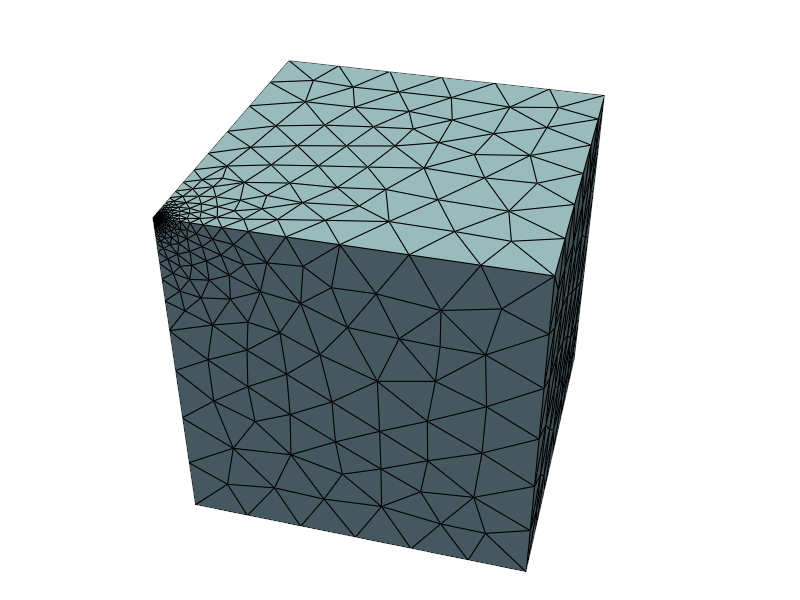

In [56]:
pl = pv.Plotter(window_size=(800, 600))
pl.add_mesh(get_pyvista_grid(mesh_cube, cell_type="tetra"), show_edges=True)
pl.camera.azimuth = -120
_ = pl.show()

In [57]:
# [output: hide]
#
radius = 0.6

mesh_sphere, pg_sphere = mesh_bottom_eighth_sphere(radius, h_min, h_max, h_corner)
grid_sphere = get_pyvista_grid(mesh_sphere, cell_type="tetra")


Info    : Cannot bind existing OpenCASCADE volume 1 to second tag 2                                                                              
Info    : Could not preserve tag of 3D object 2 (->1)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [ 20%] Meshing curve 2 (Circle)
Info    : [ 50%] Meshing curve 4 (Circle)
Info    : [ 60%] Meshing curve 5 (Line)
Info    : [ 80%] Meshing curve 6 (Line)
Info    : [ 90%] Meshing curve 7 (Line)
Info    : Done meshing 1D (Wall 0.00492711s, CPU 0.004363s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Sphere, Frontal-Delaunay)
Info    : [ 30%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 60%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : [ 80%] Meshing surface 4 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0239352s, CPU 0.024075s)
Info    : Meshing 3D...
Info    : Meshing volume 1 (Frontal)
Info    : Region 1 Face 1, 1 intersect
Info    : Region 1 Face 2, 1 intersect
Inf

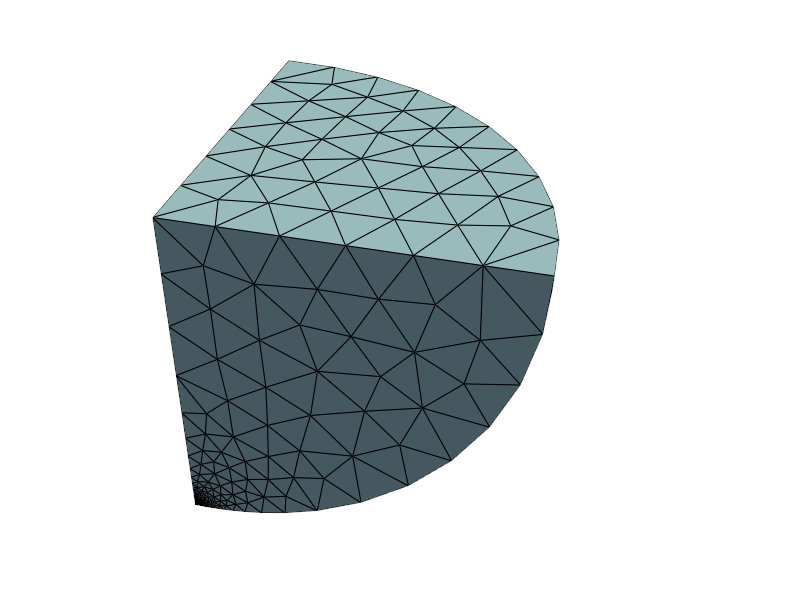

In [58]:
pl = pv.Plotter(window_size=(800, 600))
pl.add_mesh(grid_sphere, show_edges=True)
pl.camera.azimuth = -120
_ = pl.show()

## Problem setup

### System definition


Our problem includes two fields; $u_\text{cube}$ and $u_\text{sphere}$. 
To handle them, we use both [`Compound`](../api/tatva.compound.md#tatva.compound.Compound) and [`Lifter`](../api/tatva.lifter.md#tatva.lifter.Lifter) utilities.
We first declare the `Solution` as a subclass of `Compound`:


In [59]:
from tatva.compound import Compound, field


class Solution(Compound):
    u_cube = field((mesh_cube.coords.shape[0], 3))
    u_sphere = field((mesh_sphere.coords.shape[0], 3))

Then we find boundary nodes to apply BCs. 
Exploiting the symmetry in the problem, we model only a quarter of the full geometric problem.
This means, we need to constrain these respective displacements.
Finally, we apply a top displacement `z_disp` on the top surface of the sphere octant.
We construct the `lifter` for our problem:

In [60]:
from tatva.lifter import DirichletBC, Lifter

z_disp = -0.001

cube_sym_x = jnp.where(jnp.isclose(mesh_cube.coords[:, 0], 0.0))[0]
cube_sym_y = jnp.where(jnp.isclose(mesh_cube.coords[:, 1], 0.0))[0]
cube_bottom = jnp.where(jnp.isclose(mesh_cube.coords[:, 2], -1.0))[0]
sphere_sym_x = jnp.where(jnp.isclose(mesh_sphere.coords[:, 0], 0.0))[0]
sphere_sym_y = jnp.where(jnp.isclose(mesh_sphere.coords[:, 1], 0.0))[0]
sphere_top = jnp.where(
    jnp.isclose(mesh_sphere.coords[:, 2], mesh_sphere.coords[:, 2].max())
)[0]

lifter = Lifter(
    Solution.size,
    DirichletBC(Solution.u_cube[cube_sym_x, 0]),
    DirichletBC(Solution.u_cube[cube_sym_y, 1]),
    DirichletBC(Solution.u_cube[cube_bottom, 2]),
    DirichletBC(Solution.u_sphere[sphere_sym_x, 0]),
    DirichletBC(Solution.u_sphere[sphere_sym_y, 1]),
    DirichletBC(Solution.u_sphere[sphere_top, 2], z_disp),
)

Finally, we now define the two [`Operators`](../api/tatva.operator.md#tatva.operator.Operator) from the meshes and the element type. 
In this example, we use 4-node Tetrahedral elements [`Tetrahedron4`](../api/tatva.element.md#tatva.element.Tetrahedron4).

In [61]:
from tatva.element import Tetrahedron4

el = Tetrahedron4()
op_cube = Operator(mesh_cube, el)
op_sphere = Operator(mesh_sphere, el)

### Contact energy definition

Contact potential energy contribution based on gap function between two deformable meshes.
The contact contribution to the total energy is evaluated using a **two-pass node-to-surface contact detection scheme**.
The total contact energy is defined as the arithmetic mean of the two surface contributions.
This symmetric formulation avoids master–slave bias and improves robustness, particularly for comparable mesh resolutions and material stiffnesses.

**First pass (sphere → cube):**

- Each surface node of the sphere is orthogonally projected onto the cube surface.
- The normal gap is evaluated at the projection point.
- The corresponding penalty density is integrated over the sphere surface.

**Second pass (cube → sphere):**

- Each surface node of the cube is orthogonally projected onto the sphere surface.
- The normal gap is computed analogously.
- The penalty contribution is integrated over the cube surface.

To integrate across the 3d manifold, we need to define a `Tri3Manifold` element type, and we define two surface operators:

In [65]:
from tatva.element import Tri3


class Tri3Manifold(Tri3):
    """A 3-node linear triangular element on a 2D manifold embedded in 3D space."""

    def get_jacobian(self, xi: Array, nodal_coords: Array) -> tuple[Array, Array]:
        dNdr = self.shape_function_derivative(xi)
        J = dNdr @ nodal_coords  # shape (2, 2) or (2, 3)
        G = J @ J.T  # shape (2, 2)
        detJ = jnp.sqrt(jnp.linalg.det(G))
        return J, detJ

    def gradient(self, xi: Array, nodal_values: Array, nodal_coords: Array) -> Array:
        dNdr = self.shape_function_derivative(xi)  # shape (2, 3)
        J, _ = self.get_jacobian(xi, nodal_coords)  # shape (2, 3)

        G_inv = jnp.linalg.inv(J @ J.T)  # shape (2, 2)
        J_plus = J.T @ G_inv  # shape (3, 2)

        dudxi = dNdr @ nodal_values  # shape (2, n_values)
        return J_plus @ dudxi  # shape (3, n_values)


surf_op_cube = Operator(
    mesh_cube._replace(elements=pg_cube["cube_top"]), Tri3Manifold()
)

surf_op_sphere = Operator(
    mesh_sphere._replace(elements=pg_sphere["sphere_outer"]), Tri3Manifold()
)

In [63]:
# [collapse: code] Code for computing the gap function
@autovmap(x=1, el_coords=2, reference_point=1)
def _get_gap_and_inside_mask(
    x: Array, el_coords: Array, reference_point: Array, *, eps: float = 1e-12
) -> tuple[Array, Array]:
    x0, x1, x2 = el_coords
    e0 = x1 - x0
    e1 = x2 - x0

    n0 = jnp.cross(e0, e1)
    nn = jnp.vdot(n0, n0)

    def _degenerate():
        return jnp.array(False), jnp.array(0.0, dtype=x.dtype)

    def _regular():
        n = n0 / jnp.sqrt(nn)
        # orient normal (only affects gap sign)
        n = jnp.where(jnp.dot(n, x0 - reference_point) > 0.0, n, -n)

        gap = jnp.dot(x - x0, n)
        xproj = x - gap * n

        # inside test using edge half-spaces
        c0 = jnp.dot(jnp.cross(x1 - x0, xproj - x0), n)
        c1 = jnp.dot(jnp.cross(x2 - x1, xproj - x1), n)
        c2 = jnp.dot(jnp.cross(x0 - x2, xproj - x2), n)

        inside = (c0 >= -eps) & (c1 >= -eps) & (c2 >= -eps)
        return inside, gap

    return jax.lax.cond(nn < eps**2, _degenerate, _regular)


def get_gap(x: Array, el_coords: Array, reference_point: Array) -> Array:
    mask, gap = _get_gap_and_inside_mask(x, el_coords, reference_point)
    return jnp.min(jnp.where(mask, gap, jnp.inf))


In [102]:
@jax.jit
def contact_energy(x_cube: Array, x_sphere: Array, *, kappa: float = 1e4) -> Array:
    """Contact energy with cube as master surface.

    Args:
        x_cube: (n_cube_nodes, 3) array of cube node coordinates
        x_sphere: (n_sphere_nodes, 3) array of sphere node coordinates
        kappa: penalty stiffness parameter
    """
    # for each sphere surface quad point, compute gap to cube surface
    gap = jax.vmap(
        lambda x: get_gap(x, x_cube[pg_cube["cube_top"]], jnp.array([0.1, 0.1, -1.0])),
        in_axes=0,
    )(surf_op_sphere.eval(x_sphere))

    # for each cube surface quad point, compute gap to sphere surface
    gap_inv = jax.vmap(
        lambda x: get_gap(
            x,
            x_sphere[pg_sphere["sphere_outer"]],
            jnp.array([0.1, 0.1, radius + 0.1]),
        ),
        in_axes=0,
    )(surf_op_cube.eval(x_cube))

    # only negative gaps contribute to energy; add singleton dim for integration
    gap = jnp.minimum(gap, 0.0)[..., None]
    gap_inv = jnp.minimum(gap_inv, 0.0)[..., None]

    # return arithmetic mean of sphere and cube contributions to energy
    return 0.5 * (
        0.5 * kappa * surf_op_sphere.integrate(gap**2)
        + 0.5 * kappa * surf_op_cube.integrate(gap_inv**2)
    )

### Elastic energy definition

Here, we employ a linear elastic material model. We define the material point functions for strain and stress:

In [103]:
@autovmap(grad_u=2)
def compute_strain(grad_u: Array) -> Array:
    return 0.5 * (grad_u + grad_u.T)


@autovmap(eps=2, mu=0, lmbda=0)
def compute_stress(eps: Array, mu: float, lmbda: float) -> Array:
    I = jnp.eye(3)
    return 2 * mu * eps + lmbda * jnp.trace(eps) * I


@autovmap(grad_u=2, mu=0, lmbda=0)
def strain_energy(grad_u: Array, mu: float, lmbda: float) -> Array:
    eps = compute_strain(grad_u)
    sigma = compute_stress(eps, mu, lmbda)
    return 0.5 * jnp.einsum("ij,ij->", sigma, eps)

Let's quickly add a material utility.

In [104]:
from typing import NamedTuple


class Material(NamedTuple):
    """Material properties for the elasticity operator."""

    mu: float  # Diffusion coefficient
    lmbda: float  # Diffusion coefficient

    @classmethod
    def from_youngs_poisson(cls, E: float, nu: float) -> "Material":
        mu = E / (3 - 6 * nu)
        lmbda = E * nu / (1 - 2 * nu) / (1 + nu)
        return cls(mu=mu, lmbda=lmbda)


mat_cube = Material.from_youngs_poisson(1, 0.3)
mat_sphere = Material.from_youngs_poisson(1, 0.3)

Finally, we define the **total energy functional**:

In [105]:
@jax.jit(static_argnames=("kappa",))
def total_energy_full(u_full: Array, kappa: float = 1e2) -> Array:
    (u1, u2) = Solution(u_full)
    e1 = strain_energy(op_cube.grad(u1), mat_cube.mu, mat_cube.lmbda)
    e2 = strain_energy(op_sphere.grad(u2), mat_sphere.mu, mat_sphere.lmbda)

    # extract surface displacements, compute position, and contact energy
    xcube_surf = mesh_cube.coords + u1  # current position of all cube nodes
    xsphere_surf = mesh_sphere.coords + u2  # current position of all sphere nodes
    e_contact = contact_energy(xcube_surf, xsphere_surf, kappa=kappa)

    return op_cube.integrate(e1) + op_sphere.integrate(e2) + e_contact


@jax.jit(static_argnames=("kappa",))
def total_energy(u_free: Array, kappa: float = 1e2) -> Array:
    """Compute the total energy of the system."""
    u_full = lifter.lift_from_zeros(u_free)
    return total_energy_full(u_full, kappa=kappa)


residual_fn = jax.jacrev(total_energy)

### Solve system

In [108]:
# [collapse: code] Newton-Krylov solver

import time
from functools import partial


@partial(jax.jit, static_argnames=["gradient", "compute_tangent"])
def newton_krylov_solver(
    u,
    gradient,
    compute_tangent,
):
    residual = gradient(u)
    norm_res = jnp.linalg.norm(residual)

    init_val = (u, 0, norm_res)

    def cond_fun(state):
        u, iiter, norm_res = state
        return jnp.logical_and(norm_res > 1e-8, iiter < 10)

    def body_fun(state):
        jax.debug.print(
            "Iteration {iter}, Residual norm: {res:.2e}", iter=state[1], res=state[2]
        )
        u, iiter, norm_res = state
        residual = gradient(u)
        A = jax.jit(compute_tangent(u))

        start_time = time.time()
        du, _ = jax.scipy.sparse.linalg.cg(A, -residual, maxiter=1000)
        end_time = time.time()
        jax.block_until_ready(du)
        jax.debug.print("  CG solve time: {time:.2f} s", time=end_time - start_time)

        u = u + du

        residual = gradient(u)
        norm_res = jnp.linalg.norm(residual)
        jax.debug.print("  Residual norm: {res:.2e}", res=norm_res)

        return (u, iiter + 1, norm_res)

    final_u, final_iiter, final_norm = jax.lax.while_loop(cond_fun, body_fun, init_val)
    jax.debug.print("  Residual: {res:.2e}", res=final_norm)

    return final_u, final_norm

In [109]:
# [output: hide]
from typing import Callable

fn = partial(residual_fn, kappa=2e3)


def _jvp(loc: Array) -> Callable[[Array], Array]:
    def _jvp_fn(v: Array) -> Array:
        return jax.jvp(fn, (loc,), (v,))[1]

    return _jvp_fn


z0 = jnp.zeros(lifter.size_reduced).at[Solution.u_sphere[:, 2]].set(z_disp)
z_sol, norm_res = newton_krylov_solver(u=z0, gradient=fn, compute_tangent=_jvp)

  CG solve time: 0.03 s
Iteration 0, Residual norm: 4.11e-03
  Residual norm: 1.54e-05
  CG solve time: 0.03 s
Iteration 1, Residual norm: 1.54e-05
  Residual norm: 1.21e-05
  CG solve time: 0.03 s
Iteration 2, Residual norm: 1.21e-05
  Residual norm: 4.33e-07
  CG solve time: 0.03 s
Iteration 3, Residual norm: 4.33e-07
  Residual norm: 9.20e-08
  CG solve time: 0.03 s
Iteration 4, Residual norm: 9.20e-08
  Residual norm: 5.61e-09
  Residual: 5.61e-09


In [110]:
# Use Solution to unpack the full solution vector into displacements for cube and sphere
u1, u2 = Solution(lifter.lift_from_zeros(z_sol))

## Results

In [111]:
# [collapse: code] Function to visualize the results with PyVista
def plot_contact_result(
    mesh_sphere,
    mesh_cube,
    u_sphere,
    u_cube,
    stress_sphere,
    stress_cube,
    *,
    factor: float = 1.0,
    cmap: str = "managua",
    clim=None,
    backend: str = "static",
):
    import numpy as np
    import pyvista as pv

    def von_mises_stress(stress):
        sxx = stress[..., 0, 0]
        syy = stress[..., 1, 1]
        szz = stress[..., 2, 2]
        sxy = stress[..., 0, 1]
        syz = stress[..., 1, 2]
        szx = stress[..., 2, 0]
        return np.sqrt(
            0.5
            * (
                (sxx - syy) ** 2
                + (syy - szz) ** 2
                + (szz - sxx) ** 2
                + 6 * (sxy**2 + syz**2 + szx**2)
            )
        )

    # --- build grids ---
    grid_s = get_pyvista_grid(mesh_sphere, cell_type="tetra")
    grid_s.point_data["u"] = np.asarray(u_sphere)
    grid_s.cell_data["sig_vm"] = von_mises_stress(np.asarray(stress_sphere))
    grid_s.cell_data["sig_zz"] = np.asarray(stress_sphere[..., 2, 2])
    grid_s.cell_data["sig_zx"] = np.asarray(stress_sphere[..., 2, 0])
    grid_s.warp_by_vector("u", factor=factor, inplace=True)

    grid_c = get_pyvista_grid(mesh_cube, cell_type="tetra")
    grid_c.point_data["u"] = np.asarray(u_cube)
    grid_c.cell_data["sig_vm"] = von_mises_stress(np.asarray(stress_cube))
    grid_c.cell_data["sig_zz"] = np.asarray(stress_cube[..., 2, 2])
    grid_c.cell_data["sig_zx"] = np.asarray(stress_cube[..., 2, 0])
    grid_c.warp_by_vector("u", factor=factor, inplace=True)

    pv.set_jupyter_backend(backend)
    pl = pv.Plotter(window_size=(800, 1200))

    for g in (grid_s, grid_c):
        g.translate((-0.2, 0, 0), inplace=True)

    # --- lighting ---
    pl.remove_all_lights()
    pl.add_light(
        pv.Light(position=(-1, -10.0, 2), focal_point=(0, 0, 0), intensity=0.4)
    )
    pl.add_light(
        pv.Light(position=(-8, -15.0, 3), focal_point=(0, 0, 0), intensity=1.0)
    )

    # --- sphere ---
    surf_s = grid_s.cell_data_to_point_data()
    pl.add_mesh(
        surf_s,
        scalars="sig_vm",
        show_edges=True,
        edge_opacity=0.1,
        cmap=cmap,
        clim=clim,
        opacity=1.0,
    )
    iso_s = surf_s.extract_surface(algorithm="dataset_surface").contour(
        isosurfaces=np.logspace(-3, 0, 20), scalars="sig_vm"
    )
    pl.add_mesh(iso_s, line_width=3, cmap=cmap, clim=clim, opacity=0.6)

    # --- cube ---
    surf_c = grid_c.cell_data_to_point_data()
    pl.add_mesh(
        surf_c,
        scalars="sig_vm",
        show_edges=True,
        edge_opacity=0.1,
        cmap=cmap,
        clim=clim,
        opacity=1.0,
    )
    iso_c = surf_c.extract_surface(algorithm="dataset_surface").contour(
        isosurfaces=np.logspace(-3, 0, 20), scalars="sig_vm"
    )
    pl.add_mesh(iso_c, line_width=3, cmap=cmap, clim=clim, opacity=0.6)

    pl.add_axes(interactive=False, line_width=3)
    pl.scalar_bar.SetVisibility(False)

    pl.view_isometric()
    pl.camera.azimuth -= 160
    pl.camera.elevation -= 20
    pl.camera.position = (
        pl.camera.position[0] - 1.4,
        pl.camera.position[1] - 2,
        pl.camera.position[2] + 1,
    )
    pl.camera.zoom(2)

    return pl.show()

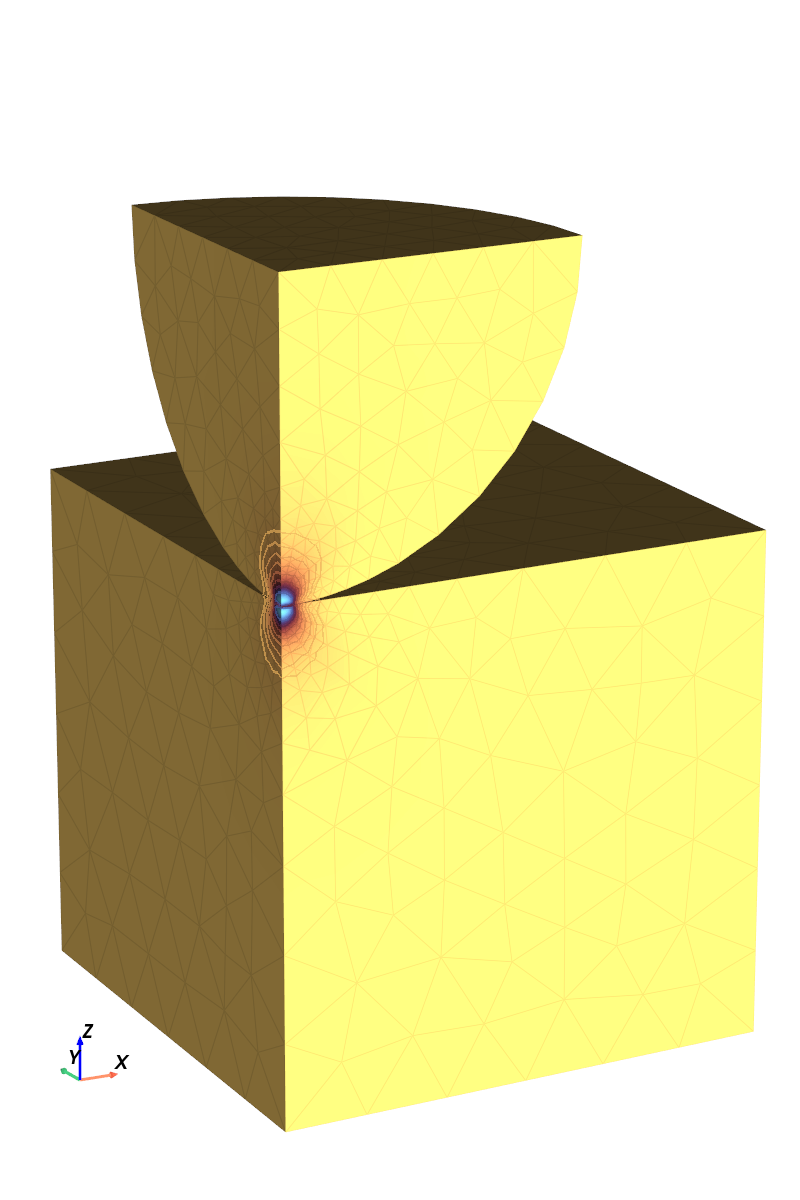

In [112]:
eps_box = compute_strain(op_cube.grad(u1))
stress_box = compute_stress(eps_box, mat_cube.mu, mat_cube.lmbda)
eps_sphere = compute_strain(op_sphere.grad(u2))
stress_sphere = compute_stress(eps_sphere, mat_sphere.mu, mat_sphere.lmbda)


plot_contact_result(mesh_sphere, mesh_cube, u2, u1, stress_sphere, stress_box)


In [113]:
# [collapse: code] Code for computing the analytical solution for Hertzian contact
def force_analytical(E: float, R: float, d: float) -> float:
    """Analytical contact force for a sphere indenting a half-space.

    Args:
        E: Young's modulus of the half-space.
        R: Radius of the sphere.
        d: Indentation depth (positive).
    """
    return 4 / 3 * E * R**0.5 * d**1.5


def get_a(R: float, d: float) -> float:
    """Hertzian contact radius from indentation depth."""
    return np.sqrt(R * d)


def p_max(F, a):
    return 3 / 2 * F / np.pi / a**2


def sig_z(z, a: float, p_max: float) -> float:
    return -p_max / (1 + (z / a) ** 2)


def get_analytical_stress(F, R, d):
    E = 1.0
    nu = 0.3
    a = get_a(R, d)
    pmax = p_max(F, a)
    return lambda z: sig_z(z, a, pmax)

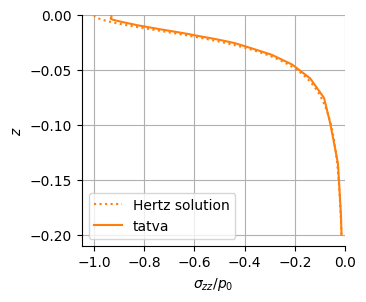

In [114]:
# [collapse: code] Create plot for $\sigma_{zz}$ along the centerline and compare to analytical solution
import matplotlib.pyplot as plt
from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator

nodal_coords = mesh_cube.coords
quad_coords = op_cube.eval(mesh_cube.coords).squeeze()

grid = get_pyvista_grid(mesh_cube, cell_type="tetra")
grid.cell_data["sig_zz"] = stress_box[..., 2, 2]
nodal_sig = np.array(grid.cell_data_to_point_data().point_data["sig_zz"])
interp = LinearNDInterpolator(nodal_coords, nodal_sig)

# z-extent of the cube
zmin = mesh_cube.coords[:, 2].min()
zmax = mesh_cube.coords[:, 2].max()

# Compute analytical solution for Hertzian contact
z_disp_abs = abs(z_disp)
radius = 0.6
E_star = 1.0 / (1 - 0.3**2)
F = force_analytical(E_star, radius, z_disp_abs)
a = get_a(radius, z_disp_abs)

fig = plt.figure(figsize=(3.4, 3.0))  # single-column width
ax = fig.add_subplot(111)


def plot_sig_zz(ax):
    zi = np.linspace(zmin + (zmax - zmin) * 0.8, zmax + z_disp_abs / 2, 200)
    p0 = p_max(F, a)
    ax.plot(
        get_analytical_stress(F, radius, z_disp_abs)(zi) / p0,
        zi,
        ":",
        label="Hertz solution",
        color="C1",
    )
    ax.plot(
        interp(np.c_[np.full_like(zi, 0.0), np.full_like(zi, 0.0), zi]) / p0,
        zi,
        "-",
        label="tatva",
        c="C1",
    )

    ax.set_xlabel(r"$\sigma_{zz} / p_0$")
    ax.set_ylabel(r"$z$")
    ax.grid()
    ax.set_xlim(right=0)
    ax.set_ylim(top=0)
    ax.legend()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


plot_sig_zz(ax)

/tmp/ipykernel_122596/4210642787.py:13: RuntimeWarning: invalid value encountered in sqrt
  return np.where(r < a, p0 * np.sqrt(1 - (r / a) ** 2), 0)


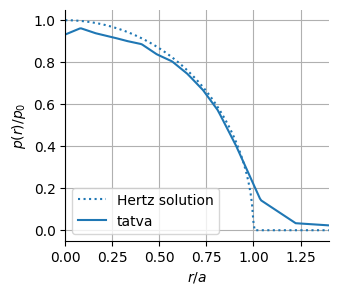

In [115]:
# [collapse: code] Create plot for traction distribution $p(r)$ and compare to analytical solution
fig = plt.figure(figsize=(3.4, 3.0))  # single-column width
ax = fig.add_subplot(111)


def plot_traction(ax):
    xi = np.linspace(0.0, 1.4 * a, 200)
    offset = 0.00

    p0 = 3 * F / 2 / np.pi / a**2

    def p_of_r(r: NDArray) -> NDArray:
        return np.where(r < a, p0 * np.sqrt(1 - (r / a) ** 2), 0)

    ax.plot(xi / a, p_of_r(xi) / p0, ":", label="Hertz solution", c="C0")
    ax.plot(
        xi / a,
        -interp(np.c_[np.full_like(xi, offset), xi, np.full_like(xi, 0)]) / p0,
        "-",
        label="tatva",
        c="C0",
    )
    ax.grid()
    ax.legend(loc="lower left")
    ax.set_xlim((0, 1.4))
    ax.set(xlabel=r"$r / a$", ylabel=r"$p(r) / p_0$")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


plot_traction(ax)